## **Dataset**

In [ ]:
!gdown 1JJjMiNieTz7xYs6UeVqd02M3DW4fnEfU
!unzip cvpr2016_flowers.zip

In [ ]:
import os

def load_captions(captions_folder, image_folder):
    captions = {}
    image_files = os.listdir(image_folder)
    for image_file in image_files:
        image_name = image_file.split('.')[0]
        caption_file = os.path.join(captions_folder, image_name + ".txt")
        with open(caption_file, "r") as f:
            caption = f.readlines()[0].strip()
        if image_name not in captions:
                captions[image_name] = caption
    return captions

In [ ]:
captions_folder = "./cvpr2016_flowers/captions"
image_folder = "./cvpr2016_flowers/images"

captions = load_captions(captions_folder, image_folder)

## **Caption Encoder**

In [ ]:
import torch
import numpy as np
from sentence_transformers import SentenceTransformer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

bert_model = SentenceTransformer("all-mpnet-base-v2").to(device)

def encode_captions(captions):
    encoded_captions = {}
    for image_name in captions.keys():
        caption = captions[image_name]
        encoded_captions[image_name] = {
            'embed': torch.tensor(bert_model.encode(caption)),
            'text': caption
        }
    return encoded_captions

In [ ]:
encoded_captions = encode_captions(captions)

## **Preprocessing**

In [ ]:
from PIL import Image
from torch.utils.data import Dataset

class FlowerDataset(Dataset):
    def __init__(self, img_dir, captions, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # Load captions
        self.captions = captions

        self.img_names = list(self.captions.keys())

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name+".jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        encoded_caption = self.captions[img_name]['embed']
        caption = self.captions[img_name]['text']

        return {
            'image': image,
            'embed_caption': encoded_caption,
            'text': caption
        }

In [ ]:
import torchvision.transforms as transforms

IMG_SIZE = 128

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

ds = FlowerDataset(
    img_dir="./cvpr2016_flowers/images",
    captions=encoded_captions,
    transform=transform
)

In [ ]:
import matplotlib.pyplot as plt

def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [ ]:
show_grid(next(iter(ds))['wrong_image'])

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1024
dataloader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
batch_sample = next(iter(dataloader))

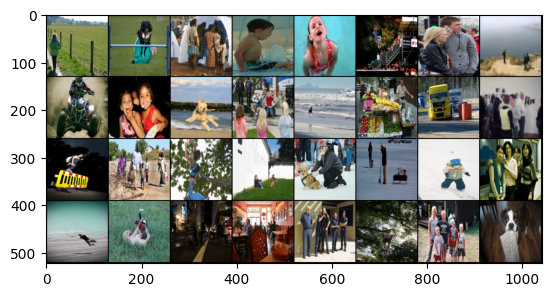

In [ ]:
# import torchvision

# show_grid(torchvision.utils.make_grid(batch_sample['image'], normalize=True))

## **Model**

In [ ]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size
        self.textEncoder = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.upsamplingBlock = nn.Sequential(
            nn.ConvTranspose2d(noise_size + reduced_dim_size, feature_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),
            nn.ConvTranspose2d(feature_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, text_embeddings):
        encoded_text = self.textEncoder(text_embeddings)
        concat_input = torch.cat((noise, encoded_text), dim=1).unsqueeze(2)
        output = self.upsamplingBlock(concat_input)
        return output

In [ ]:
generator = Generator(100, 128, 3, 768, 256).to(device)

In [ ]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        self.imageEncoder = nn.Sequential(
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.textEncoder = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        self.finalBlock = nn.Sequential(
            nn.Conv2d(feature_size * 8 + reduced_dim_size, feature_size, 1, 1, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input_img, text_embeddings):
        image_encoded = self.imageEncoder(input_img)
        text_encoded = self.textEncoder(text_embeddings)
        replicated_text = text_encoded.repeat(4, 1, 1).permute(2, 0, 1)
        x = torch.cat((image_encoded, replicated_text), 1)
        return x.view(-1, 1), image_encoded

In [ ]:
discriminator = Discriminator(3, 128, 768, 256).to(device)

## **Training**

In [ ]:
bce_loss = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

In [ ]:
plt_o_text_embeddings = ds[0]['embed_caption'].unsqueeze(0)
plt_o_text_embeddings.shape

torch.Size([1, 768])

In [ ]:
fixed_noise = torch.randn(size=(1, 100))
fixed_noise.shape

torch.Size([1, 100])

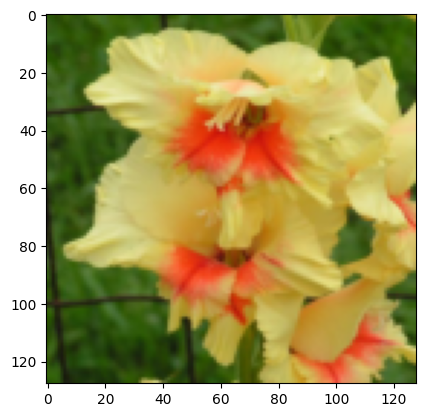

In [ ]:
import torchvision

show_grid(torchvision.utils.make_grid(ds[0]['image'], normalize=True))

In [ ]:
def plot_output(generator):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise.to(device), plt_o_text_embeddings.to(device))
    generator.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

In [ ]:
import torch.optim as optim

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
import time

epochs = 500

for epoch in range(epochs):

    d_losses, g_losses = [], []

    epoch_time = time.time()

    for batch in dataloader:
        images = batch["image"].to(device)
        embed_captions = batch["embed_caption"].to(device)
        wrong_images = batch["wrong_image"].to(device)

        # labels
        real_labels = torch.ones(images.size(0), 1, device=device)
        fake_labels = torch.zeros(images.size(0), 1, device=device)

        # Training the discriminator
        optimizer_D.zero_grad()

        # Gen fake image
        noise = torch.randn(size=(images.size(0), 100), device=device)
        fake_images = generator(noise, embed_captions)

        # Compute real loss
        outputs, _ = discriminator(images, embed_captions)
        real_loss = bce_loss(outputs, real_labels)

        # Compute contrastive loss for wrong image
        outputs, _ = discriminator(wrong_images, embed_captions)
        wrong_loss = bce_loss(outputs, fake_labels)

        # Compute fake loss
        outputs, _ = discriminator(fake_images.detach(), embed_captions)
        fake_loss = bce_loss(outputs, fake_labels)

        d_loss = real_loss + fake_loss + wrong_loss

        # Update weight
        d_loss.backward()
        optimizer_D.step()
        d_losses.append(d_loss.item())

        # Training generator
        optimizer_G.zero_grad()
        # create noise
        noise = torch.randn(size=(images.size(0), 100), device=device)
        fake_images = generator(noise, embed_captions)

        outputs, fake_features = discriminator(fake_images, embed_captions)
        _, real_features = discriminator(images, embed_captions)
        activation_fake = torch.mean(fake_features)
        activation_real = torch.mean(real_features)

        # Compute loss
        real_loss = bce_loss(outputs, real_labels)
        g_loss = real_loss + 100 * l2_loss(activation_fake, activation_real).detach() + 50 * l1_loss(fake_images, images)
        g_loss.backward()
        optimizer_G.step()
        g_losses.append(real_loss.item())

    avg_d_loss = sum(d_losses)/len(d_losses)
    avg_g_loss = sum(g_losses)/len(g_losses)

    if (epoch+1) % 10 == 0:
        plot_output(generator)


    print('Epoch [{}/{}] loss_D: {:.4f} loss_G: {:.4f} time: {:.2f}'.format(
        epoch+1, epochs,
        avg_d_loss,
        avg_g_loss,
        time.time() - epoch_time)
    )

## **Prediction**

In [ ]:
generator.eval()

noise = torch.randn(size=(1, 100))
text_embedding = ds[10]['embed_caption'].unsqueeze(0)

with torch.no_grad():
    test_images = generator(noise.to(device), text_embedding.to(device))
grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
show_grid(grid)

In [ ]:
import torch

# Save generator
torch.save(generator.state_dict(), 'generator.pth')

# Save discriminator
torch.save(discriminator.state_dict(), 'discriminator.pth')